In [27]:
from pathlib import Path
import pandas as pd

DATA_ROOT = Path("..") / "data"   # notebook lives in notebooks/, so go up one
csv_path  = DATA_ROOT / "U.S._Chronic_Disease_Indicators.csv"

assert csv_path.exists(), f"CSV not found at {csv_path}"

# Fast load with dtype inference off for speed; we'll fix types later
df = pd.read_csv(csv_path, low_memory=False)

df.shape, df.columns.tolist()[:15]


((309215, 34),
 ['YearStart',
  'YearEnd',
  'LocationAbbr',
  'LocationDesc',
  'DataSource',
  'Topic',
  'Question',
  'Response',
  'DataValueUnit',
  'DataValueType',
  'DataValue',
  'DataValueAlt',
  'DataValueFootnoteSymbol',
  'DataValueFootnote',
  'LowConfidenceLimit'])

In [28]:
# high-level info
df.info()

# missing values overview
nulls = df.isna().sum().sort_values(ascending=False)
nulls.head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309215 entries, 0 to 309214
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   YearStart                  309215 non-null  int64  
 1   YearEnd                    309215 non-null  int64  
 2   LocationAbbr               309215 non-null  object 
 3   LocationDesc               309215 non-null  object 
 4   DataSource                 309215 non-null  object 
 5   Topic                      309215 non-null  object 
 6   Question                   309215 non-null  object 
 7   Response                   0 non-null       float64
 8   DataValueUnit              309215 non-null  object 
 9   DataValueType              309215 non-null  object 
 10  DataValue                  209196 non-null  float64
 11  DataValueAlt               209196 non-null  float64
 12  DataValueFootnoteSymbol    101716 non-null  object 
 13  DataValueFootnote          10

StratificationID3            309215
StratificationCategoryID3    309215
StratificationID2            309215
StratificationCategoryID2    309215
Stratification3              309215
StratificationCategory3      309215
Response                     309215
Stratification2              309215
ResponseID                   309215
StratificationCategory2      309215
DataValueFootnoteSymbol      207499
DataValueFootnote            207499
LowConfidenceLimit           120330
HighConfidenceLimit          120325
DataValueAlt                 100019
DataValue                    100019
Geolocation                    5763
LocationID                        0
QuestionID                        0
TopicID                           0
dtype: int64

In [29]:
# Drop columns that have 0 non-null values
empty_cols = [c for c in df.columns if df[c].isna().all()]
print("Completely empty columns:", empty_cols)


# Drop columns that are over 95% null (optional, to reduce noise)
threshold = 0.95
mostly_empty = [c for c in df.columns if df[c].isna().mean() > threshold]
print("Mostly empty columns:", mostly_empty)

df = df.drop(columns=empty_cols)
df.shape

Completely empty columns: ['Response', 'StratificationCategory2', 'Stratification2', 'StratificationCategory3', 'Stratification3', 'ResponseID', 'StratificationCategoryID2', 'StratificationID2', 'StratificationCategoryID3', 'StratificationID3']
Mostly empty columns: ['Response', 'StratificationCategory2', 'Stratification2', 'StratificationCategory3', 'Stratification3', 'ResponseID', 'StratificationCategoryID2', 'StratificationID2', 'StratificationCategoryID3', 'StratificationID3']


(309215, 24)

In [30]:
df.columns


Index(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource',
       'Topic', 'Question', 'DataValueUnit', 'DataValueType', 'DataValue',
       'DataValueAlt', 'DataValueFootnoteSymbol', 'DataValueFootnote',
       'LowConfidenceLimit', 'HighConfidenceLimit', 'StratificationCategory1',
       'Stratification1', 'Geolocation', 'LocationID', 'TopicID', 'QuestionID',
       'DataValueTypeID', 'StratificationCategoryID1', 'StratificationID1'],
      dtype='object')

In [31]:
for col in ["Topic", "Question", "DataValueType", "LocationAbbr", "StratificationCategory1", "Stratification1"]:
    if col in df.columns:
        print(f"\n{col}:")
        print("Unique values:", df[col].nunique())
        print(df[col].dropna().unique()[:10])



Topic:
Unique values: 19
['Health Status' 'Cancer' 'Diabetes' 'Sleep' 'Immunization'
 'Nutrition, Physical Activity, and Weight Status' 'Oral Health'
 'Arthritis' 'Asthma' 'Cardiovascular Disease']

Question:
Unique values: 109
['Recent activity limitation among adults'
 'Invasive cancer (all sites combined), incidence'
 'Cervical cancer mortality among all females, underlying cause'
 'Prostate cancer mortality among all males, underlying cause'
 'Breast cancer mortality among all females, underlying cause'
 'Invasive cancer (all sites combined) mortality among all people, underlying cause'
 'Diabetic ketoacidosis mortality among all people, underlying or contributing cause'
 'Lung and bronchial cancer mortality among all people, underlying cause'
 'Colon and rectum (colorectal) cancer mortality among all people, underlying cause'
 'Short sleep duration among children aged 4 months to 14 years']

DataValueType:
Unique values: 12
['Age-adjusted Mean' 'Number' 'Crude Rate' 'Age-adjusted

In [32]:
numeric_cols = ["DataValue", "DataValueAlt", "LowConfidenceLimit", "HighConfidenceLimit"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].median())


In [33]:
df[numeric_cols].isna().sum()


DataValue              0
DataValueAlt           0
LowConfidenceLimit     0
HighConfidenceLimit    0
dtype: int64

In [34]:
df.select_dtypes(include=["number"]).columns


Index(['YearStart', 'YearEnd', 'DataValue', 'DataValueAlt',
       'LowConfidenceLimit', 'HighConfidenceLimit', 'LocationID'],
      dtype='object')

In [35]:
# Try to coerce every object column to numeric and see which ones succeed
possible_numeric = []
for col in df.select_dtypes(include=["object"]).columns:
    converted = pd.to_numeric(df[col], errors="coerce")
    ratio_numeric = converted.notna().mean()
    if ratio_numeric > 0.7:  # if 70%+ of the values are numeric-like
        possible_numeric.append(col)

print("Possible numeric columns:", possible_numeric)


Possible numeric columns: []


In [36]:
df[["YearStart", "YearEnd", "DataValue", "LowConfidenceLimit", "HighConfidenceLimit"]].describe().T


,count,mean,std,min,25%,50%,75%,max
YearStart,309215.0,2020.012195,1.530835,2015.0,2019.0,2020.0,2021.0,2022.0
YearEnd,309215.0,2020.288540,1.068591,2019.0,2019.0,2020.0,2021.0,2022.0
DataValue,309215.0,478.492924,13331.275156,0.0,18.4,27.0,38.1,2925456.0
LowConfidenceLimit,309215.0,30.083065,51.519253,0.0,15.1,19.5,25.3,1427.0
HighConfidenceLimit,309215.0,39.481271,55.319226,0.0,22.6,29.2,36.2,1485.9


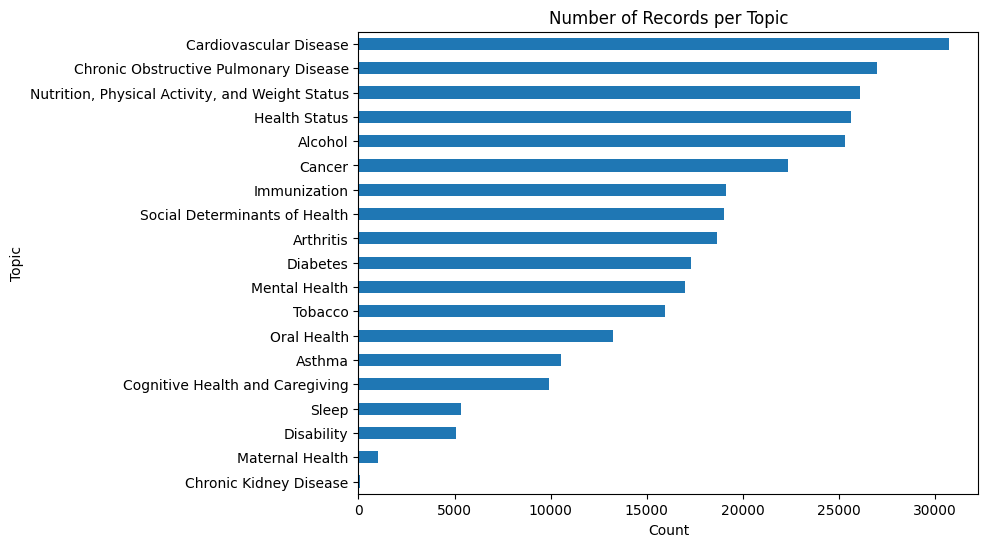

In [37]:
import matplotlib.pyplot as plt

topic_counts = df["Topic"].value_counts().sort_values(ascending=True)
plt.figure(figsize=(8,6))
topic_counts.plot(kind='barh')
plt.title("Number of Records per Topic")
plt.xlabel("Count")
plt.ylabel("Topic")
plt.show()


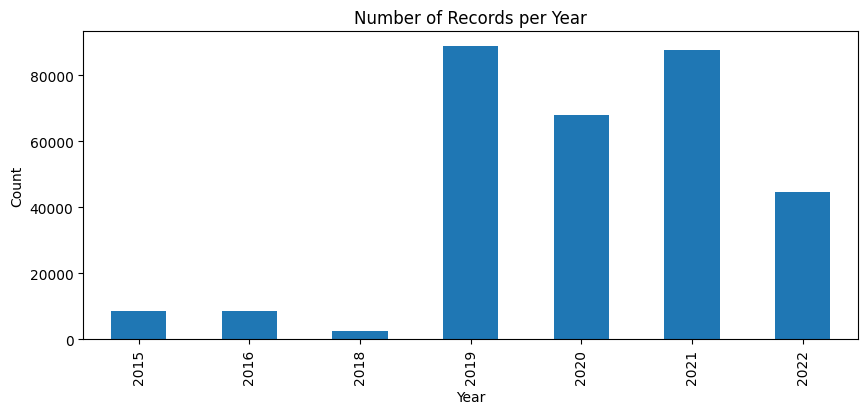

In [38]:
if "YearStart" in df.columns:
    df["YearStart"].value_counts().sort_index().plot(kind='bar', figsize=(10,4))
    plt.title("Number of Records per Year")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.show()


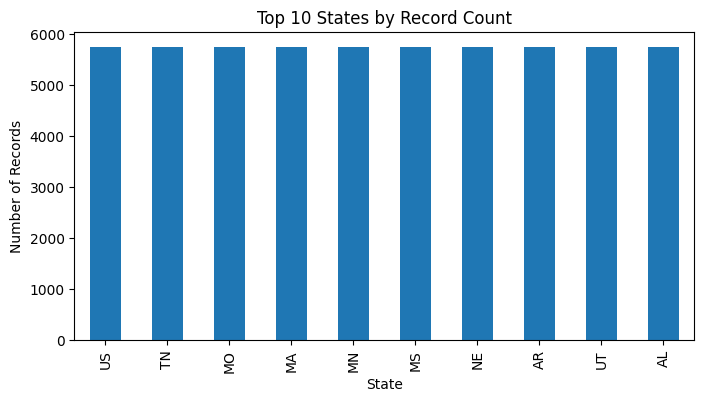

In [39]:
if "LocationAbbr" in df.columns:
    df["LocationAbbr"].value_counts().head(10).plot(kind='bar', figsize=(8,4))
    plt.title("Top 10 States by Record Count")
    plt.xlabel("State")
    plt.ylabel("Number of Records")
    plt.show()


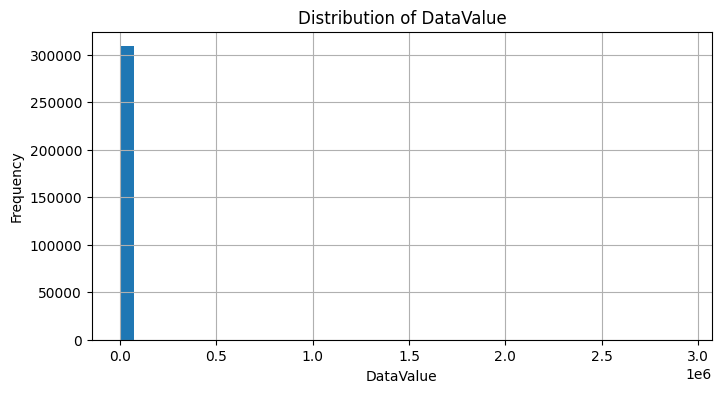

Median DataValue: 27.0


In [40]:
df["DataValue"].hist(bins=40, figsize=(8,4))
plt.title("Distribution of DataValue")
plt.xlabel("DataValue")
plt.ylabel("Frequency")
plt.show()

print("Median DataValue:", df["DataValue"].median())


In [41]:
df[df["DataValue"] > 1000][["Topic", "Question", "DataValueType", "DataValue"]].head(15)


,Topic,Question,DataValueType,DataValue
1,Cancer,"Invasive cancer (all sites combined), incidence",Number,9537.0
3,Cancer,"Invasive cancer (all sites combined), incidence",Number,2880.0
5,Cancer,"Invasive cancer (all sites combined), incidence",Number,8102.0
6,Cancer,"Invasive cancer (all sites combined), incidence",Number,9238.0
7,Cancer,"Invasive cancer (all sites combined), incidence",Number,5587.0
8,Cancer,"Breast cancer mortality among all females, und...",Number,2547.0
12,Cancer,Invasive cancer (all sites combined) mortality...,Number,314982.0
18,Cancer,Lung and bronchial cancer mortality among all ...,Number,1408.0
19,Cancer,"Breast cancer mortality among all females, und...",Number,4503.0
22,Cancer,"Invasive cancer (all sites combined), incidence",Number,1479.0


In [42]:
# Keep only percentage, rate, or mean-based metrics
mask = df["DataValueType"].str.contains("Rate|Prevalence|Mean|Median|Percent", case=False, na=False)
df_filtered = df[mask & (df["DataValue"] < 1000)].copy()

print("Original:", len(df), "→ Filtered:", len(df_filtered))


Original: 309215 → Filtered: 280926


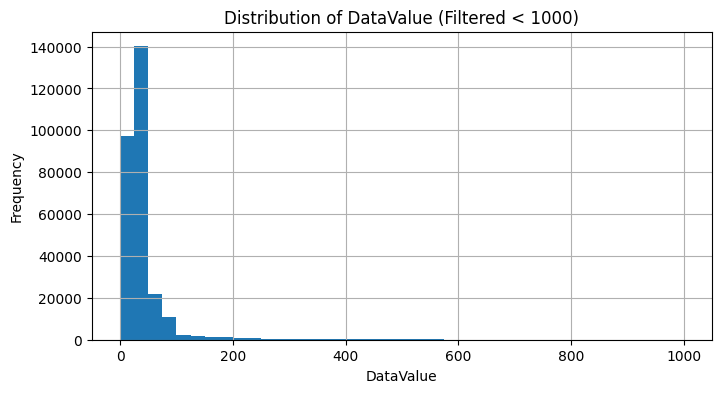

Median DataValue (filtered): 27.0


In [43]:
df_filtered["DataValue"].hist(bins=40, figsize=(8,4))
plt.title("Distribution of DataValue (Filtered < 1000)")
plt.xlabel("DataValue")
plt.ylabel("Frequency")
plt.show()

print("Median DataValue (filtered):", df_filtered["DataValue"].median())


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


print("Shape:", df.shape)
display(df.head())
df.info()

# Missingness report
miss = (df.isna()
          .sum()
          .rename("n_missing")
          .to_frame()
          .assign(pct=lambda x: 100*x["n_missing"]/len(df))
          .sort_values("pct", ascending=False))
display(miss.head(20))


Shape: (309215, 34)


,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,TopicID,QuestionID,ResponseID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2020,2020,US,United States,BRFSS,Health Status,Recent activity limitation among adults,NaN,Number,Age-adjusted Mean,...,HEA,HEA04,NaN,AGEADJMEAN,SEX,SEXF,NaN,NaN,NaN,NaN
1,2015,2019,AR,Arkansas,US Cancer DVT,Cancer,"Invasive cancer (all sites combined), incidence",NaN,Number,Number,...,CAN,CAN07,NaN,NMBR,SEX,SEXM,NaN,NaN,NaN,NaN
2,2015,2019,CA,California,US Cancer DVT,Cancer,"Cervical cancer mortality among all females, u...",NaN,Number,Number,...,CAN,CAN03,NaN,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2015,2019,CO,Colorado,US Cancer DVT,Cancer,"Invasive cancer (all sites combined), incidence",NaN,Number,Number,...,CAN,CAN07,NaN,NMBR,RACE,HIS,NaN,NaN,NaN,NaN
4,2015,2019,GA,Georgia,US Cancer DVT,Cancer,"Prostate cancer mortality among all males, und...",NaN,Number,Number,...,CAN,CAN05,NaN,NMBR,RACE,WHT,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309215 entries, 0 to 309214
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   YearStart                  309215 non-null  int64  
 1   YearEnd                    309215 non-null  int64  
 2   LocationAbbr               309215 non-null  object 
 3   LocationDesc               309215 non-null  object 
 4   DataSource                 309215 non-null  object 
 5   Topic                      309215 non-null  object 
 6   Question                   309215 non-null  object 
 7   Response                   0 non-null       float64
 8   DataValueUnit              309215 non-null  object 
 9   DataValueType              309215 non-null  object 
 10  DataValue                  209196 non-null  float64
 11  DataValueAlt               209196 non-null  float64
 12  DataValueFootnoteSymbol    101716 non-null  object 
 13  DataValueFootnote          10

,n_missing,pct
StratificationID3,309215,100.000000
StratificationCategoryID3,309215,100.000000
StratificationID2,309215,100.000000
StratificationCategoryID2,309215,100.000000
Stratification3,309215,100.000000
StratificationCategory3,309215,100.000000
Response,309215,100.000000
Stratification2,309215,100.000000
ResponseID,309215,100.000000
StratificationCategory2,309215,100.000000


In [49]:
# Try to coerce numeric-looking text columns
obj_cols = [c for c in df.columns if df[c].dtype == "object"]
for c in obj_cols:
    s = df[c].astype(str).str.strip()
    looks_numeric = s.str.match(r"^-?\d+(\.\d+)?$").mean() > 0.5
    if looks_numeric:
        df[c] = pd.to_numeric(s, errors="coerce")

# Try to parse date-like columns (replace the threshold if needed)
for c in obj_cols:
    try:
        parsed = pd.to_datetime(df[c], errors="raise", infer_datetime_format=True, utc=False)
        # adopt if at least half parse
        if (~parsed.isna()).mean() >= 0.5:
            df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True, utc=False)
    except Exception:
        pass


/var/folders/l9/fkqj0xbx05z6vp_r9lkx5_d40000gn/T/ipykernel_37057/1592627920.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(df[c], errors="raise", infer_datetime_format=True, utc=False)
/var/folders/l9/fkqj0xbx05z6vp_r9lkx5_d40000gn/T/ipykernel_37057/1592627920.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[c], errors="raise", infer_datetime_format=True, utc=False)
/var/folders/l9/fkqj0xbx05z6vp_r9lkx5_d40000gn/T/ipykernel_37057/1592627920.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it 

In [50]:
before = len(df)
df = df.drop_duplicates()
print(f"Removed {before - len(df)} exact duplicate rows.")

# If there is a known primary key column, check it
# pk = "your_id_col"
# assert not df[pk].duplicated().any(), "Primary key has duplicates!"


Removed 0 exact duplicate rows.


,count,mean,std,min,25%,50%,75%,max
YearStart,309215.0,2020.012195,1.530835,2015.0,2019.0,2020.0,2021.0,2022.0
YearEnd,309215.0,2020.288540,1.068591,2019.0,2019.0,2020.0,2021.0,2022.0
Response,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DataValue,209196.0,694.356855,16203.413041,0.0,12.4,27.0,57.8,2925456.0
DataValueAlt,209196.0,735.670102,18347.150622,0.0,12.4,27.0,57.8,2925456.0
LowConfidenceLimit,188885.0,36.825051,65.025590,0.0,9.1,19.5,40.3,1427.0
HighConfidenceLimit,188890.0,46.030554,69.995643,0.0,14.0,29.2,54.3,1485.9
StratificationCategory2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stratification2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StratificationCategory3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


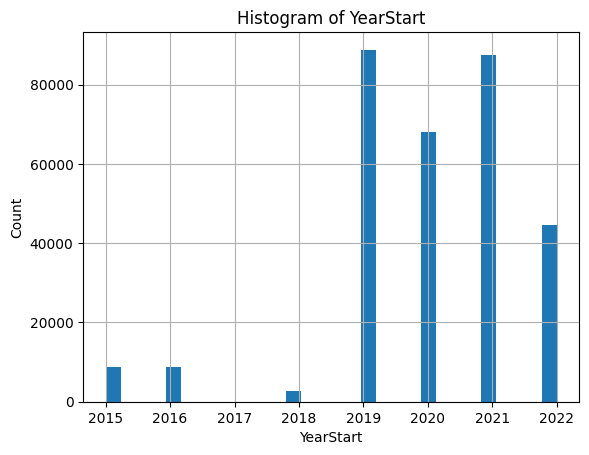

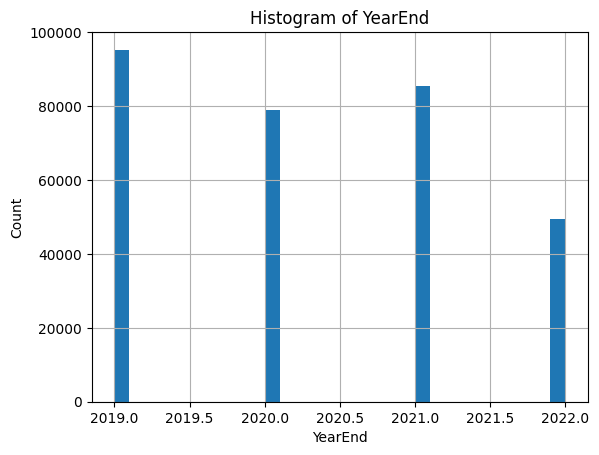

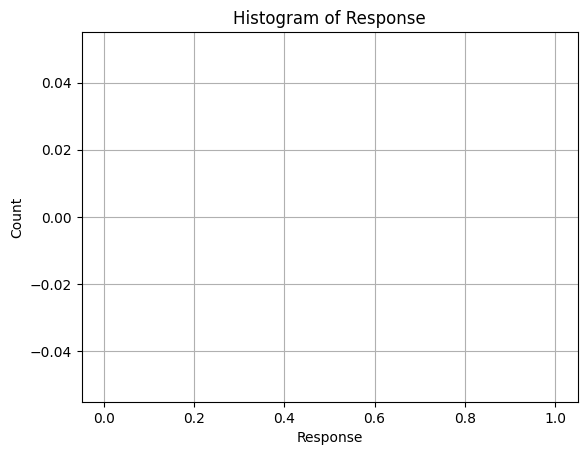

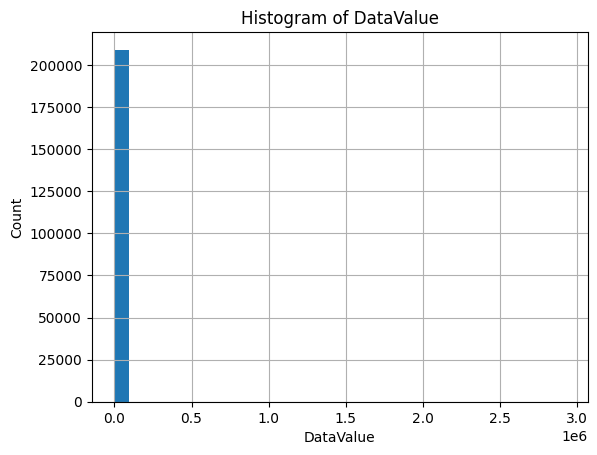

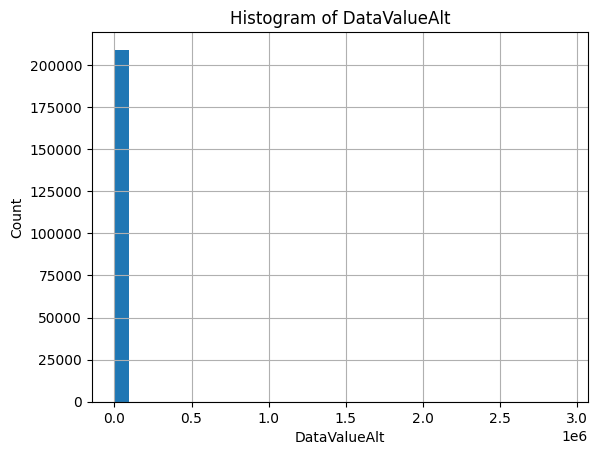

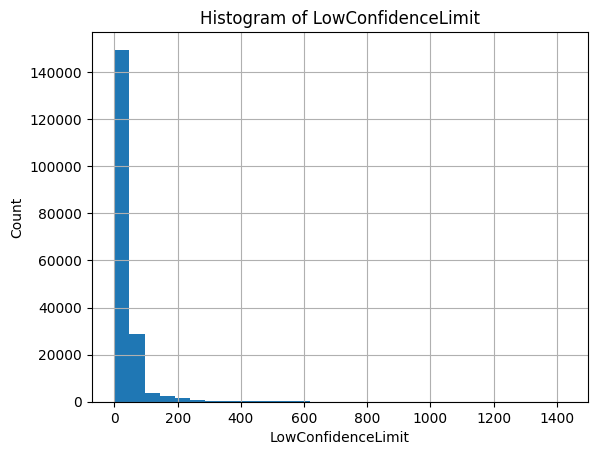

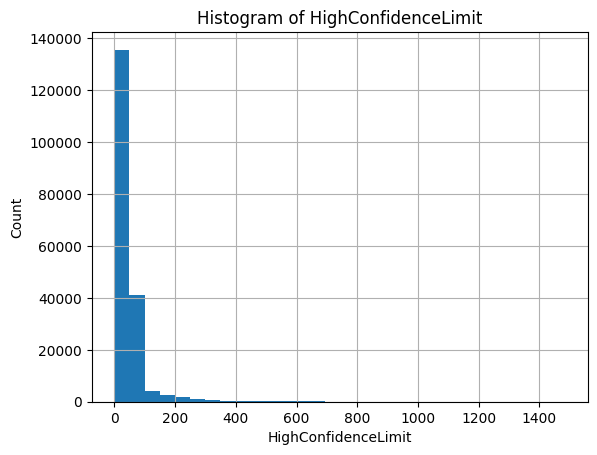

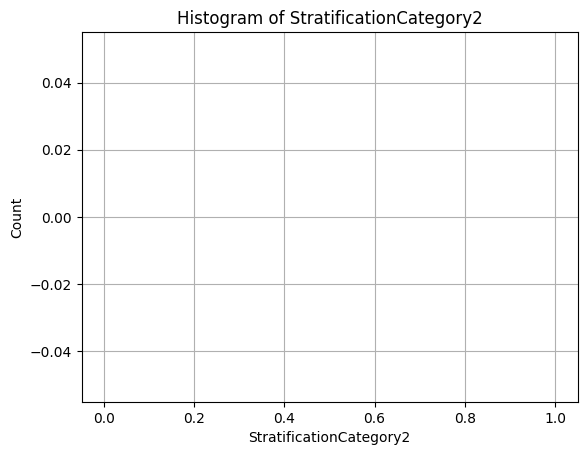

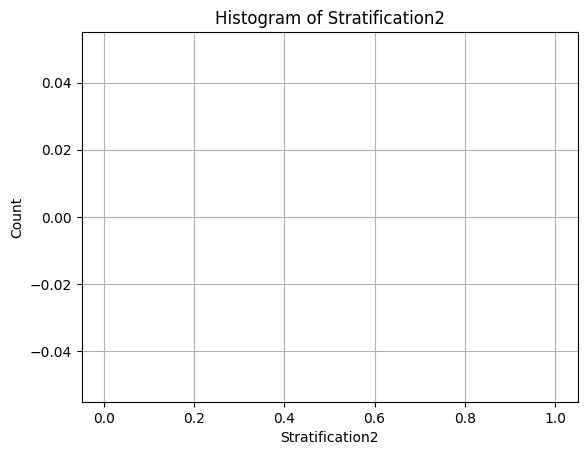

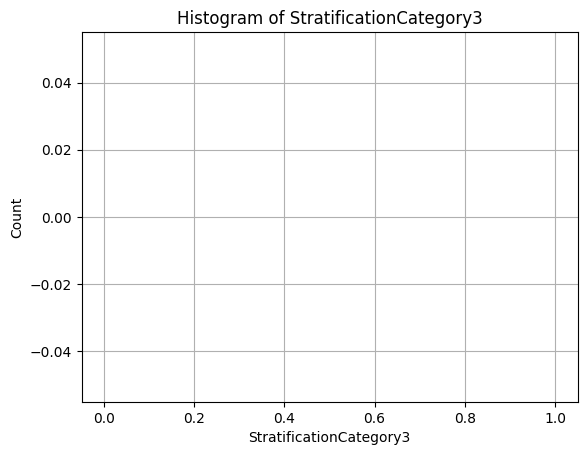

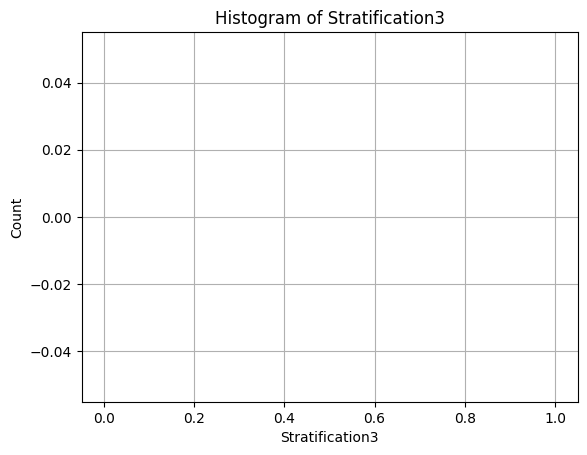

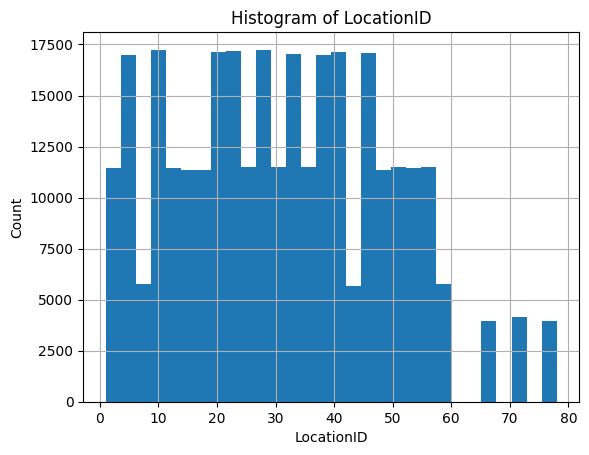

,value,count
0,US,5763
1,TN,5750
2,WY,5748
3,ND,5748
4,NY,5748
5,AL,5748
6,MS,5748
7,MO,5748
8,MN,5748
9,MI,5748


,value,count
0,United States,5763
1,Tennessee,5750
2,Alabama,5748
3,North Dakota,5748
4,Michigan,5748
5,Minnesota,5748
6,Mississippi,5748
7,Missouri,5748
8,Nebraska,5748
9,New Jersey,5748


,value,count
0,BRFSS,195594
1,NVSS,50232
2,YRBSS,17710
3,US Cancer DVT,17520
4,CMS Part A Claims Data,11232
5,PRAMS,7182
6,NSCH,5356
7,ACS,3224
8,WIC Participant and Program Characteristics,432
9,NIS,244


,value,count
0,Cardiovascular Disease,30709
1,Chronic Obstructive Pulmonary Disease,26951
2,"Nutrition, Physical Activity, and Weight Status",26069
3,Health Status,25612
4,Alcohol,25321
5,Cancer,22358
6,Immunization,19140
7,Social Determinants of Health,19026
8,Arthritis,18645
9,Diabetes,17318


,value,count
0,Binge drinking frequency among adults who bing...,5720
1,Binge drinking intensity among adults who bing...,5680
2,Cerebrovascular disease (stroke) mortality amo...,5616
3,"Diabetes mortality among all people, underlyin...",5616
4,Chronic liver disease mortality among all peop...,5616
5,Diabetic ketoacidosis mortality among all peop...,5616
6,Diseases of the heart mortality among all peop...,5616
7,Coronary heart disease mortality among all peo...,5616
8,"Asthma mortality among all people, underlying ...",5616
9,Chronic obstructive pulmonary disease mortalit...,5304


,value,count
0,%,203382
1,Number,54104
2,"cases per 100,000",31980
3,"per 100,000",11680
4,"cases per 1,000",7488
5,Years,312
6,gallons,165
7,"cases per 1,000,000",104


,value,count
0,Crude Prevalence,128198
1,Age-adjusted Prevalence,75019
2,Number,27888
3,Crude Rate,27524
4,Age-adjusted Rate,23624
5,Crude Mean,8580
6,Age-adjusted Mean,6600
7,Crude Median,5720
8,Crude 75th percentile,5680
9,Per capita alcohol consumption gallons,165


,value,count
0,nan,207499
1,****,52652
2,~,28763
3,*,12833
4,#,5738
5,###,937
6,&,535
7,##,126
8,~~~~,84
9,~~,48


,value,count
0,nan,207499
1,Data suppressed; denominator < 50 or relative ...,52652
2,Data suppressed; too few respondents or cases,28763
3,No data available,12833
4,No data available for this indicator because t...,5738
5,Interpret with caution: 95% confidence interva...,937
6,Interpret with caution; less than 60 respondents,535
7,Estimate is 0.0% because no cases were reporte...,126
8,The state registry opted not to present state-...,84
9,Data cannot be calculated,48


,value,count
0,Race/Ethnicity,188664
1,Sex,53818
2,Age,32472
3,Overall,29201
4,Grade,5060


In [51]:
# Numeric summaries
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
display(df[num_cols].describe().T)

# Quick histograms (matplotlib; one plot per column)
for c in num_cols[:12]:   # cap to a subset if there are many
    plt.figure()
    df[c].dropna().hist(bins=30)
    plt.title(f"Histogram of {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.show()

# Categorical frequencies
cat_cols = [c for c in df.columns if df[c].dtype == "object" or str(df[c].dtype).startswith("category")]
for c in cat_cols[:10]:
    vc = df[c].astype("category").value_counts(dropna=False).head(20)
    display(pd.DataFrame({"value": vc.index.astype(str), "count": vc.values}))


/var/folders/l9/fkqj0xbx05z6vp_r9lkx5_d40000gn/T/ipykernel_37057/4271794209.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


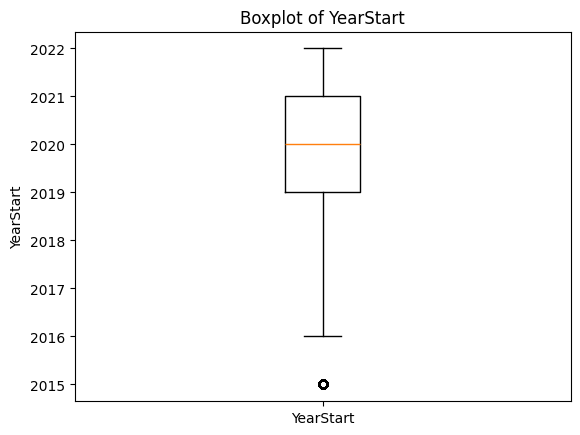

/var/folders/l9/fkqj0xbx05z6vp_r9lkx5_d40000gn/T/ipykernel_37057/4271794209.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


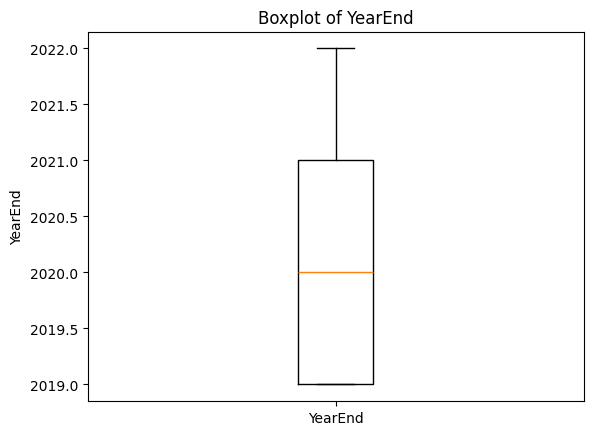

/var/folders/l9/fkqj0xbx05z6vp_r9lkx5_d40000gn/T/ipykernel_37057/4271794209.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


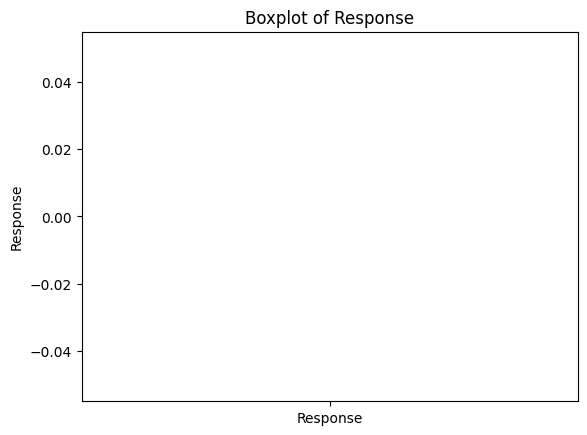

/var/folders/l9/fkqj0xbx05z6vp_r9lkx5_d40000gn/T/ipykernel_37057/4271794209.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


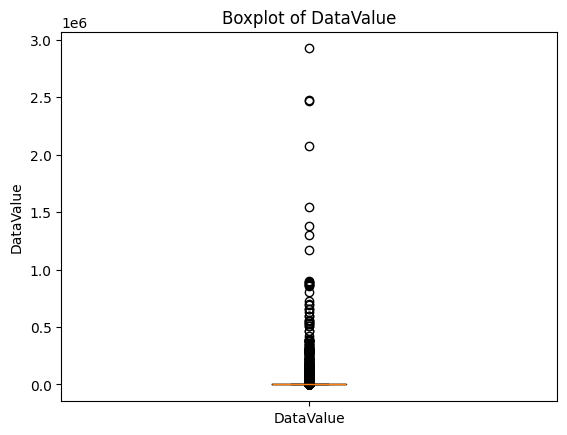

/var/folders/l9/fkqj0xbx05z6vp_r9lkx5_d40000gn/T/ipykernel_37057/4271794209.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


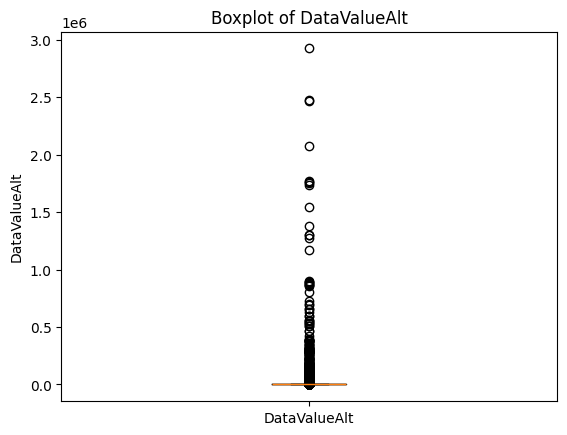

/var/folders/l9/fkqj0xbx05z6vp_r9lkx5_d40000gn/T/ipykernel_37057/4271794209.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


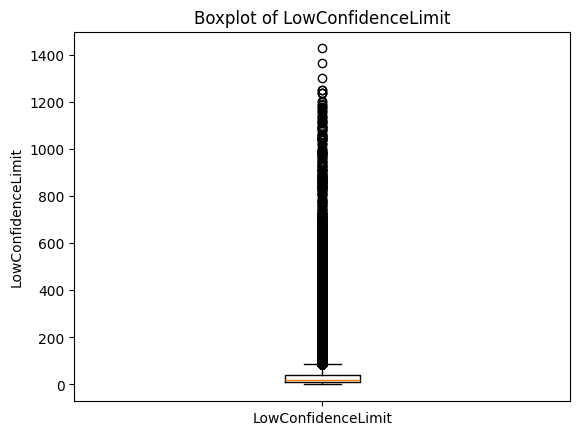

/var/folders/l9/fkqj0xbx05z6vp_r9lkx5_d40000gn/T/ipykernel_37057/4271794209.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


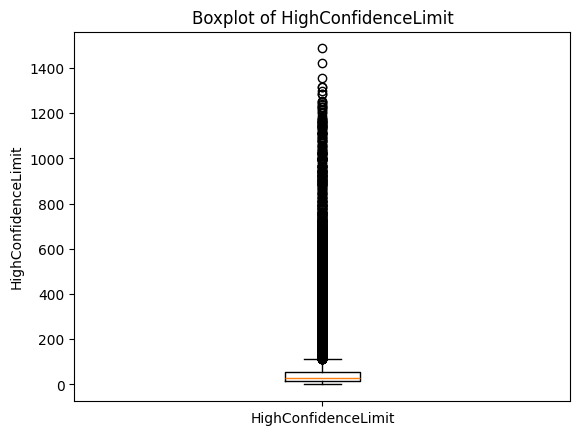

/var/folders/l9/fkqj0xbx05z6vp_r9lkx5_d40000gn/T/ipykernel_37057/4271794209.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


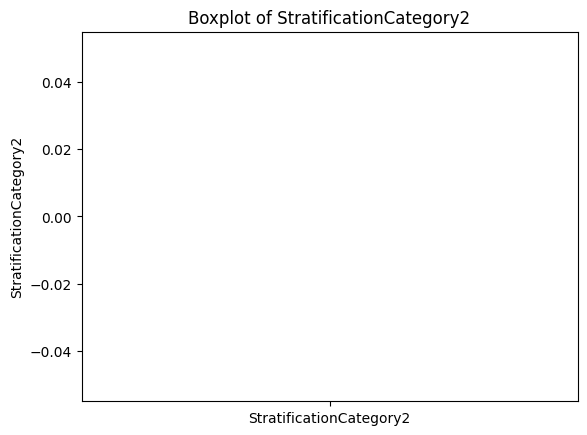

/var/folders/l9/fkqj0xbx05z6vp_r9lkx5_d40000gn/T/ipykernel_37057/4271794209.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


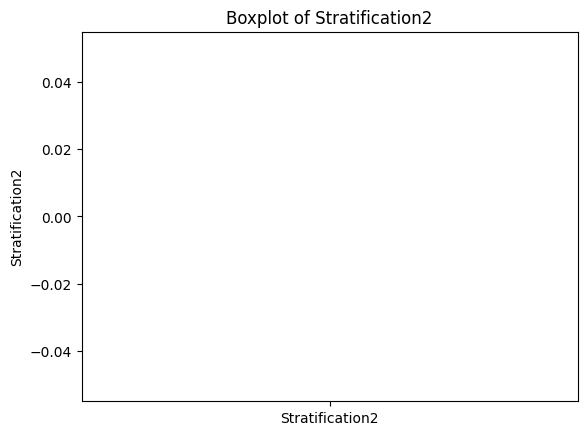

/var/folders/l9/fkqj0xbx05z6vp_r9lkx5_d40000gn/T/ipykernel_37057/4271794209.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


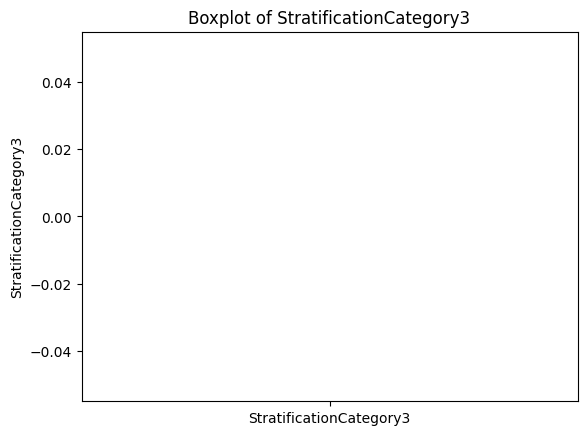

/var/folders/l9/fkqj0xbx05z6vp_r9lkx5_d40000gn/T/ipykernel_37057/4271794209.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


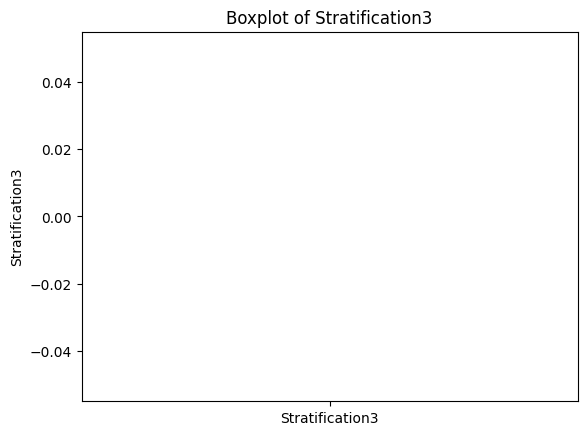

/var/folders/l9/fkqj0xbx05z6vp_r9lkx5_d40000gn/T/ipykernel_37057/4271794209.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


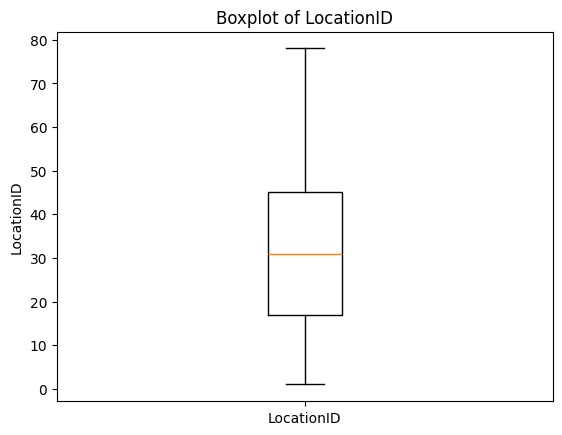

In [52]:
def iqr_bounds(s, k=1.5):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr

# Visual check with boxplots
for c in num_cols[:12]:
    plt.figure()
    plt.boxplot(df[c].dropna(), vert=True, labels=[c])
    plt.title(f"Boxplot of {c}")
    plt.ylabel(c)
    plt.show()

# Optional: cap outliers (winsorize) — only do this if appropriate for your analysis
cap_cols = num_cols  # or a curated subset
for c in cap_cols:
    lo, hi = iqr_bounds(df[c].dropna())
    df[c] = df[c].clip(lower=lo, upper=hi)


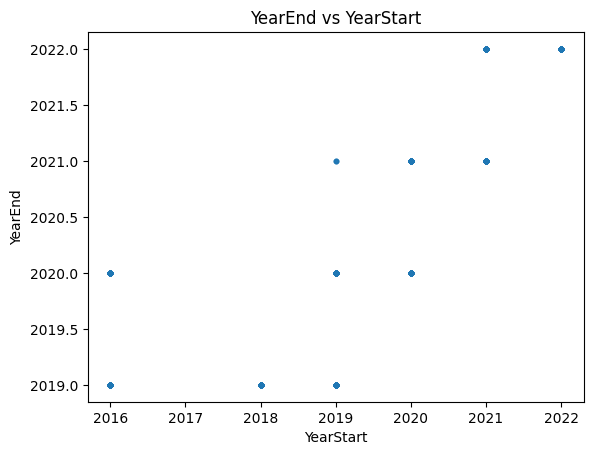

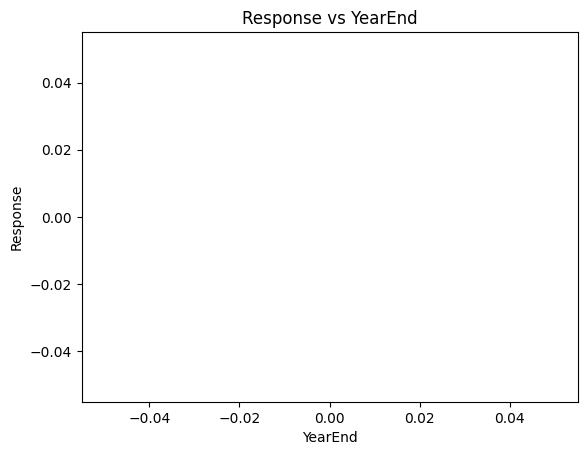

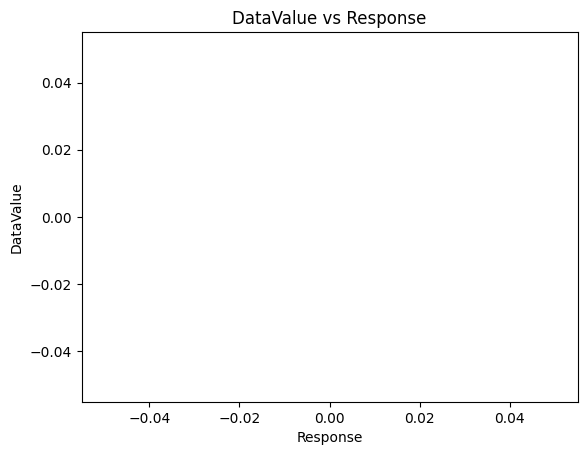

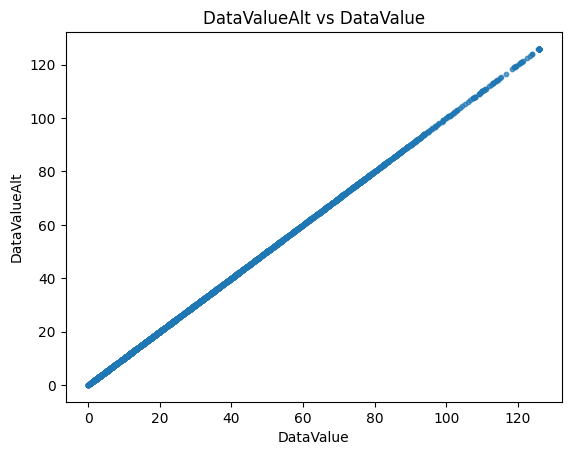

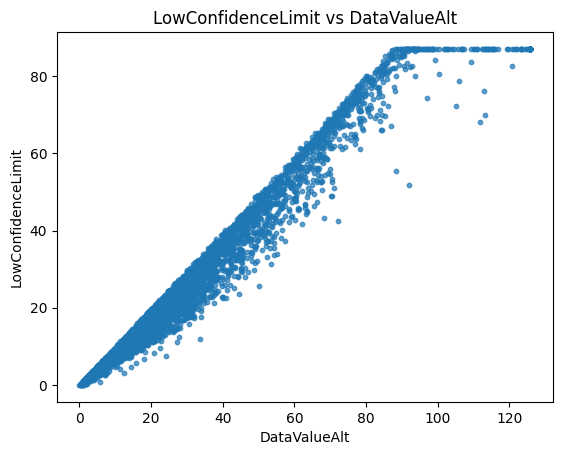

,YearStart,YearEnd,Response,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory2,Stratification2,StratificationCategory3,Stratification3,LocationID,ResponseID,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
LocationAbbr,,,,,,,,,,,,,,,,,
VI,2020.393046,2020.452003,NaN,27.160408,27.160408,19.683772,35.546784,NaN,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN
GU,2020.393046,2020.452003,NaN,27.320439,27.320439,21.358662,34.089901,NaN,NaN,NaN,NaN,66.0,NaN,NaN,NaN,NaN,NaN
PR,2020.327892,2020.424388,NaN,27.953607,27.953607,24.564305,30.575288,NaN,NaN,NaN,NaN,72.0,NaN,NaN,NaN,NaN,NaN
OK,2020.037168,2020.295221,NaN,43.895793,43.895793,30.663714,40.670151,NaN,NaN,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN
WV,2020.036849,2020.292683,NaN,44.926908,44.926908,31.993083,42.362183,NaN,NaN,NaN,NaN,54.0,NaN,NaN,NaN,NaN,NaN
SC,2020.028745,2020.289056,NaN,40.650662,40.650662,28.347494,37.503032,NaN,NaN,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN
IN,2020.028745,2020.289056,NaN,41.330646,41.330646,29.097230,38.110539,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN
ID,2020.028745,2020.289056,NaN,38.858907,38.858907,26.996241,36.487994,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN
NV,2020.028745,2020.289056,NaN,41.891788,41.891788,28.086938,39.274820,NaN,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN


,YearStart,YearEnd,Response,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory2,Stratification2,StratificationCategory3,Stratification3,LocationID,ResponseID,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
LocationDesc,,,,,,,,,,,,,,,,,
Guam,2020.393046,2020.452003,NaN,27.320439,27.320439,21.358662,34.089901,NaN,NaN,NaN,NaN,66.0,NaN,NaN,NaN,NaN,NaN
Virgin Islands,2020.393046,2020.452003,NaN,27.160408,27.160408,19.683772,35.546784,NaN,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN
Puerto Rico,2020.327892,2020.424388,NaN,27.953607,27.953607,24.564305,30.575288,NaN,NaN,NaN,NaN,72.0,NaN,NaN,NaN,NaN,NaN
Oklahoma,2020.037168,2020.295221,NaN,43.895793,43.895793,30.663714,40.670151,NaN,NaN,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN
West Virginia,2020.036849,2020.292683,NaN,44.926908,44.926908,31.993083,42.362183,NaN,NaN,NaN,NaN,54.0,NaN,NaN,NaN,NaN,NaN
Ohio,2020.028745,2020.289056,NaN,42.380660,42.380660,29.207218,38.830702,NaN,NaN,NaN,NaN,39.0,NaN,NaN,NaN,NaN,NaN
Indiana,2020.028745,2020.289056,NaN,41.330646,41.330646,29.097230,38.110539,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN
South Carolina,2020.028745,2020.289056,NaN,40.650662,40.650662,28.347494,37.503032,NaN,NaN,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN
Texas,2020.028745,2020.289056,NaN,41.749531,41.749531,27.866392,36.836445,NaN,NaN,NaN,NaN,48.0,NaN,NaN,NaN,NaN,NaN


,YearStart,YearEnd,Response,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory2,Stratification2,StratificationCategory3,Stratification3,LocationID,ResponseID,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
DataSource,,,,,,,,,,,,,,,,,
BRFSS,2020.449533,2020.500169,NaN,27.645561,27.645561,23.881799,31.836573,NaN,NaN,NaN,NaN,31.855716,NaN,NaN,NaN,NaN,NaN
YRBSS,2020.043478,2020.043478,NaN,21.488105,21.488105,17.225303,27.304119,NaN,NaN,NaN,NaN,31.854545,NaN,NaN,NaN,NaN,NaN
ACS,2020.000000,2020.000000,NaN,37.750118,37.750118,34.648325,40.418171,NaN,NaN,NaN,NaN,29.538462,NaN,NaN,NaN,NaN,NaN
AEDS,2020.000000,2020.000000,NaN,2.557949,2.557949,NaN,NaN,NaN,NaN,NaN,NaN,31.854545,NaN,NaN,NaN,NaN,NaN
ANRF,2020.000000,2020.000000,NaN,32.328712,32.328712,NaN,NaN,NaN,NaN,NaN,NaN,31.854545,NaN,NaN,NaN,NaN,NaN
CMS Part A Claims Data,2020.000000,2020.000000,NaN,63.823050,63.823050,33.629345,40.750075,NaN,NaN,NaN,NaN,29.538462,NaN,NaN,NaN,NaN,NaN
WIC Participant and Program Characteristics,2020.000000,2020.000000,NaN,13.768215,13.768215,12.277995,15.635941,NaN,NaN,NaN,NaN,31.351852,NaN,NaN,NaN,NaN,NaN
NVSS,2019.996894,2019.996894,NaN,81.327027,81.327027,51.970337,68.026969,NaN,NaN,NaN,NaN,29.538462,NaN,NaN,NaN,NaN,NaN
PRAMS,2019.959064,2019.959064,NaN,47.977131,47.977131,41.937898,53.563500,NaN,NaN,NaN,NaN,31.028265,NaN,NaN,NaN,NaN,NaN


,YearStart,YearEnd,Response,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory2,Stratification2,StratificationCategory3,Stratification3,LocationID,ResponseID,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
Topic,,,,,,,,,,,,,,,,,
Social Determinants of Health,2020.651792,2020.657574,NaN,44.620257,44.620257,40.411981,48.020189,NaN,NaN,NaN,NaN,31.372963,NaN,NaN,NaN,NaN,NaN
Disability,2020.500000,2020.500000,NaN,30.014520,30.014520,25.607173,34.976644,NaN,NaN,NaN,NaN,31.854545,NaN,NaN,NaN,NaN,NaN
Immunization,2020.500000,2020.500000,NaN,44.907401,44.907401,39.303071,50.815986,NaN,NaN,NaN,NaN,31.854545,NaN,NaN,NaN,NaN,NaN
Mental Health,2020.489986,2020.489986,NaN,14.776679,14.776679,12.041577,18.328608,NaN,NaN,NaN,NaN,31.804607,NaN,NaN,NaN,NaN,NaN
Health Status,2020.487818,2020.487818,NaN,12.278650,12.278650,10.299520,14.626458,NaN,NaN,NaN,NaN,31.826331,NaN,NaN,NaN,NaN,NaN
Oral Health,2020.487156,2020.703234,NaN,52.536645,52.536645,46.794928,58.081628,NaN,NaN,NaN,NaN,31.790496,NaN,NaN,NaN,NaN,NaN
Alcohol,2020.325027,2020.325027,NaN,19.352600,19.352600,9.612190,14.276516,NaN,NaN,NaN,NaN,31.354212,NaN,NaN,NaN,NaN,NaN
Tobacco,2020.314983,2020.314983,NaN,24.392952,24.392952,19.912295,29.815582,NaN,NaN,NaN,NaN,31.801331,NaN,NaN,NaN,NaN,NaN
Sleep,2020.241068,2020.475743,NaN,46.791040,46.791040,40.848025,52.786705,NaN,NaN,NaN,NaN,31.311019,NaN,NaN,NaN,NaN,NaN


,YearStart,YearEnd,Response,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory2,Stratification2,StratificationCategory3,Stratification3,LocationID,ResponseID,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
Question,,,,,,,,,,,,,,,,,
Lack of social and emotional support needed among adults,2022.000000,2022.000000,NaN,10.536409,10.536409,8.216779,13.576342,NaN,NaN,NaN,NaN,31.854545,NaN,NaN,NaN,NaN,NaN
Lack of reliable transportation in the past 12 months among adults,2022.000000,2022.000000,NaN,9.740468,9.740468,7.458054,12.805537,NaN,NaN,NaN,NaN,31.854545,NaN,NaN,NaN,NaN,NaN
"Unable to pay mortgage, rent, or utility bills in the past 12 months among adults",2022.000000,2022.000000,NaN,13.960323,13.960323,11.058548,17.598387,NaN,NaN,NaN,NaN,31.854545,NaN,NaN,NaN,NaN,NaN
Mammography use among women aged 50-74 years,2021.001138,2021.001138,NaN,76.115446,76.115446,68.482325,82.055096,NaN,NaN,NaN,NaN,31.823663,NaN,NaN,NaN,NaN,NaN
No teeth lost among adults aged 18-64 years,2021.000000,2021.000000,NaN,64.374210,64.374210,58.941015,69.302745,NaN,NaN,NaN,NaN,31.854545,NaN,NaN,NaN,NaN,NaN
Current poor mental health among high school students,2021.000000,2021.000000,NaN,30.617925,30.617925,24.997877,37.241274,NaN,NaN,NaN,NaN,31.854545,NaN,NaN,NaN,NaN,NaN
Short sleep duration among adults,2021.000000,2021.000000,NaN,36.389409,36.389409,31.387707,41.771584,NaN,NaN,NaN,NaN,31.854545,NaN,NaN,NaN,NaN,NaN
Six or more teeth lost among adults aged 65 years and older,2021.000000,2021.000000,NaN,34.957340,34.957340,29.650345,40.592228,NaN,NaN,NaN,NaN,31.854545,NaN,NaN,NaN,NaN,NaN
All teeth lost among adults aged 65 years and older,2021.000000,2021.000000,NaN,14.484668,14.484668,11.370605,18.389844,NaN,NaN,NaN,NaN,31.854545,NaN,NaN,NaN,NaN,NaN


In [53]:
# Numeric vs numeric (scatter)
pairs = []
if len(num_cols) >= 2:
    pairs = [(num_cols[i], num_cols[i+1]) for i in range(min(5, len(num_cols)-1))]
for x, y in pairs:
    data = df[[x, y]].dropna()
    if len(data) > 5000:
        data = data.sample(5000, random_state=42)
    plt.figure()
    plt.scatter(data[x], data[y], s=10, alpha=0.7)
    plt.title(f"{y} vs {x}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

# Categorical vs numeric (grouped means)
for cat in cat_cols[:5]:
    grp = df.groupby(cat)[num_cols].mean(numeric_only=True).sort_values(num_cols[0] if num_cols else cat, ascending=False).head(10)
    display(grp)
